In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

In [2]:
L = 1.0  #domai length
nx, ny = 41, 81    # Number of grid points in x and y
dx = L / (nx - 1)
dy = L / (ny - 1)
max_iter = 10000
tolerance = 1e-6   # for Convergence

In [3]:
def source_term(x, y):
    return 50000 * np.exp(-50 * ((1 - x) ** 2 + y ** 2)) * (100 * ((1 - x) ** 2 + y ** 2) - 2)

In [4]:
# Defining the given boundary conditions
def phi_bc(x, y, bound):
    if bound == 'L':
        return 500 * np.exp(-50 * (1 + y ** 2))
    elif bound == 'R':
        return 100 * (1 - y) + 500 * np.exp(-50 * y ** 2)
    elif bound == 'B':
        return 100 * x + 500 * np.exp(-50 * (1 - x) ** 2)
    elif bound == 'T':
        return 500 * np.exp(-50 * ((1 - x) ** 2 + 1))

In [5]:
## the Thomas Algorithm
def tdma(a, b, c, d):
    n = len(d)
    c_new = np.zeros(n)
    d_new = np.zeros(n)

    c_new[0] = c[0] / b[0]
    d_new[0] = d[0] / b[0]

    for i in range(1, n):
        factor = b[i] - a[i] * c_new[i - 1]
        c_new[i] = c[i] / factor
        d_new[i] = (d[i] - a[i] * d_new[i - 1]) / factor

    x = np.zeros(n)
    x[-1] = d_new[-1]
    for i in range(n - 2, -1, -1):
        x[i] = d_new[i] - c_new[i] * x[i + 1]

    return x

In [6]:
phi = np.zeros((ny, nx))

# SetTing up boundary conditions
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)

In [7]:
for j in range(ny):
    phi[j, 0] = phi_bc(0, y[j], 'L')    
    phi[j, -1] = phi_bc(1, y[j], 'R')   

for i in range(nx):
    phi[0, i] = phi_bc(x[i], 0, 'B')
    phi[-1, i] = phi_bc(x[i], 1, 'T')    

# ADI method
residuals = []
for k in range(max_iter):
    
    phi_old = np.copy(phi)
    # First doing the row sweep
    for j in range(1, ny-1):
        a = np.ones(nx-2) / dx**2
        b = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx-2)
        c = np.ones(nx-2) / dx**2
        d = -source_term(x[1:-1], y[j])

        d = d - ((phi[j+1, 1:-1] + phi[j-1, 1:-1]) / dy**2)

        phi[j, 1:-1] = tdma(a, b, c, d)  #using the thomas algorithm in order to solve for the current row
    
    
    # Then doing the column sweep
    for i in range(1, nx-1):
        a = np.ones(ny-2) / dy**2
        b = -2 * (1/dx**2 + 1/dy**2) * np.ones(ny-2)
        c = np.ones(ny-2) / dy**2
        d = -source_term(x[i], y[1:-1])

        d = d -((phi[1:-1, i+1] + phi[1:-1, i-1]) / dx**2)

        phi[1:-1, i] = tdma(a, b, c, d)  #tdma for solving for cuurent coluumn
        
    #calculating the error and checking for convergence
    err = np.linalg.norm(phi - phi_old)
    residuals.append(err)
    if err < tolerance:
        print(f'Converged after {k+1} iterations')
        break

Converged after 1101 iterations


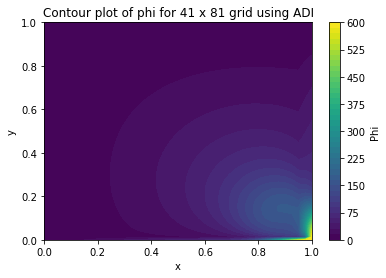

In [8]:
# Plotting the contour of our solution
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, phi, 50, cmap='viridis')
plt.colorbar(label='Phi')
plt.title(f'Contour plot of phi for {nx} x {ny} grid using ADI')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

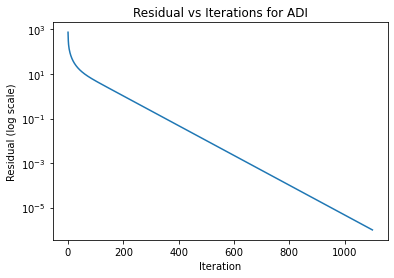

In [9]:
plt.plot(residuals)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Residual vs Iterations for ADI')
plt.show()